In [1]:
import os
import glob
import re
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"


# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")


In [3]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [4]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [5]:
# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)

    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\moff_20230717_train.shp
Image: C:\Users\Student\D

In [6]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
unique_labels = le.classes_

# Calculate the mean and standard deviation for each class
mean_profiles = []
std_profiles = []

for class_index in range(len(unique_labels)):
    class_features = features[encoded_labels == class_index]
    mean_profiles.append(np.mean(class_features, axis=0))
    std_profiles.append(np.std(class_features, axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

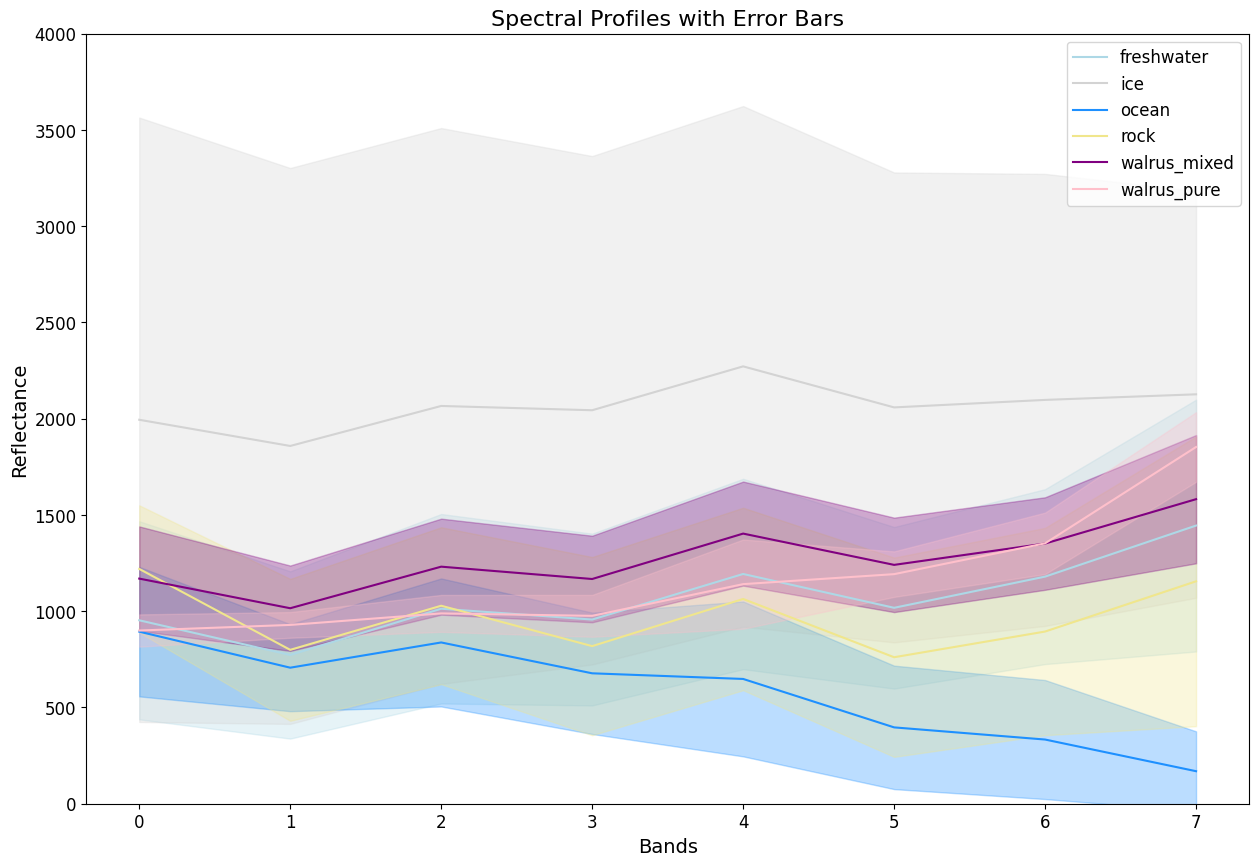

In [13]:
# Define colors for each class
colors = {
    'freshwater': 'lightblue',
    'ice': 'lightgrey',
    'ocean': 'dodgerblue',
    'rock': 'khaki', 
    'walrus_mixed': 'purple',
    'walrus_pure': 'pink'
}

# Plot the spectral profiles with filled error bars and specified colors
bands = np.arange(features.shape[1])

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    plt.plot(bands, mean, label=class_label, color=colors.get(class_label, 'black'))
    plt.fill_between(bands, mean - std, mean + std, color=colors.get(class_label, 'black'), alpha=0.3)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles with Error Bars', fontsize=16)
plt.legend(fontsize=12)
plt.grid(False)  # Remove the strong grid background
plt.ylim([0, 4000])  # Limit the y-axis to 4000
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


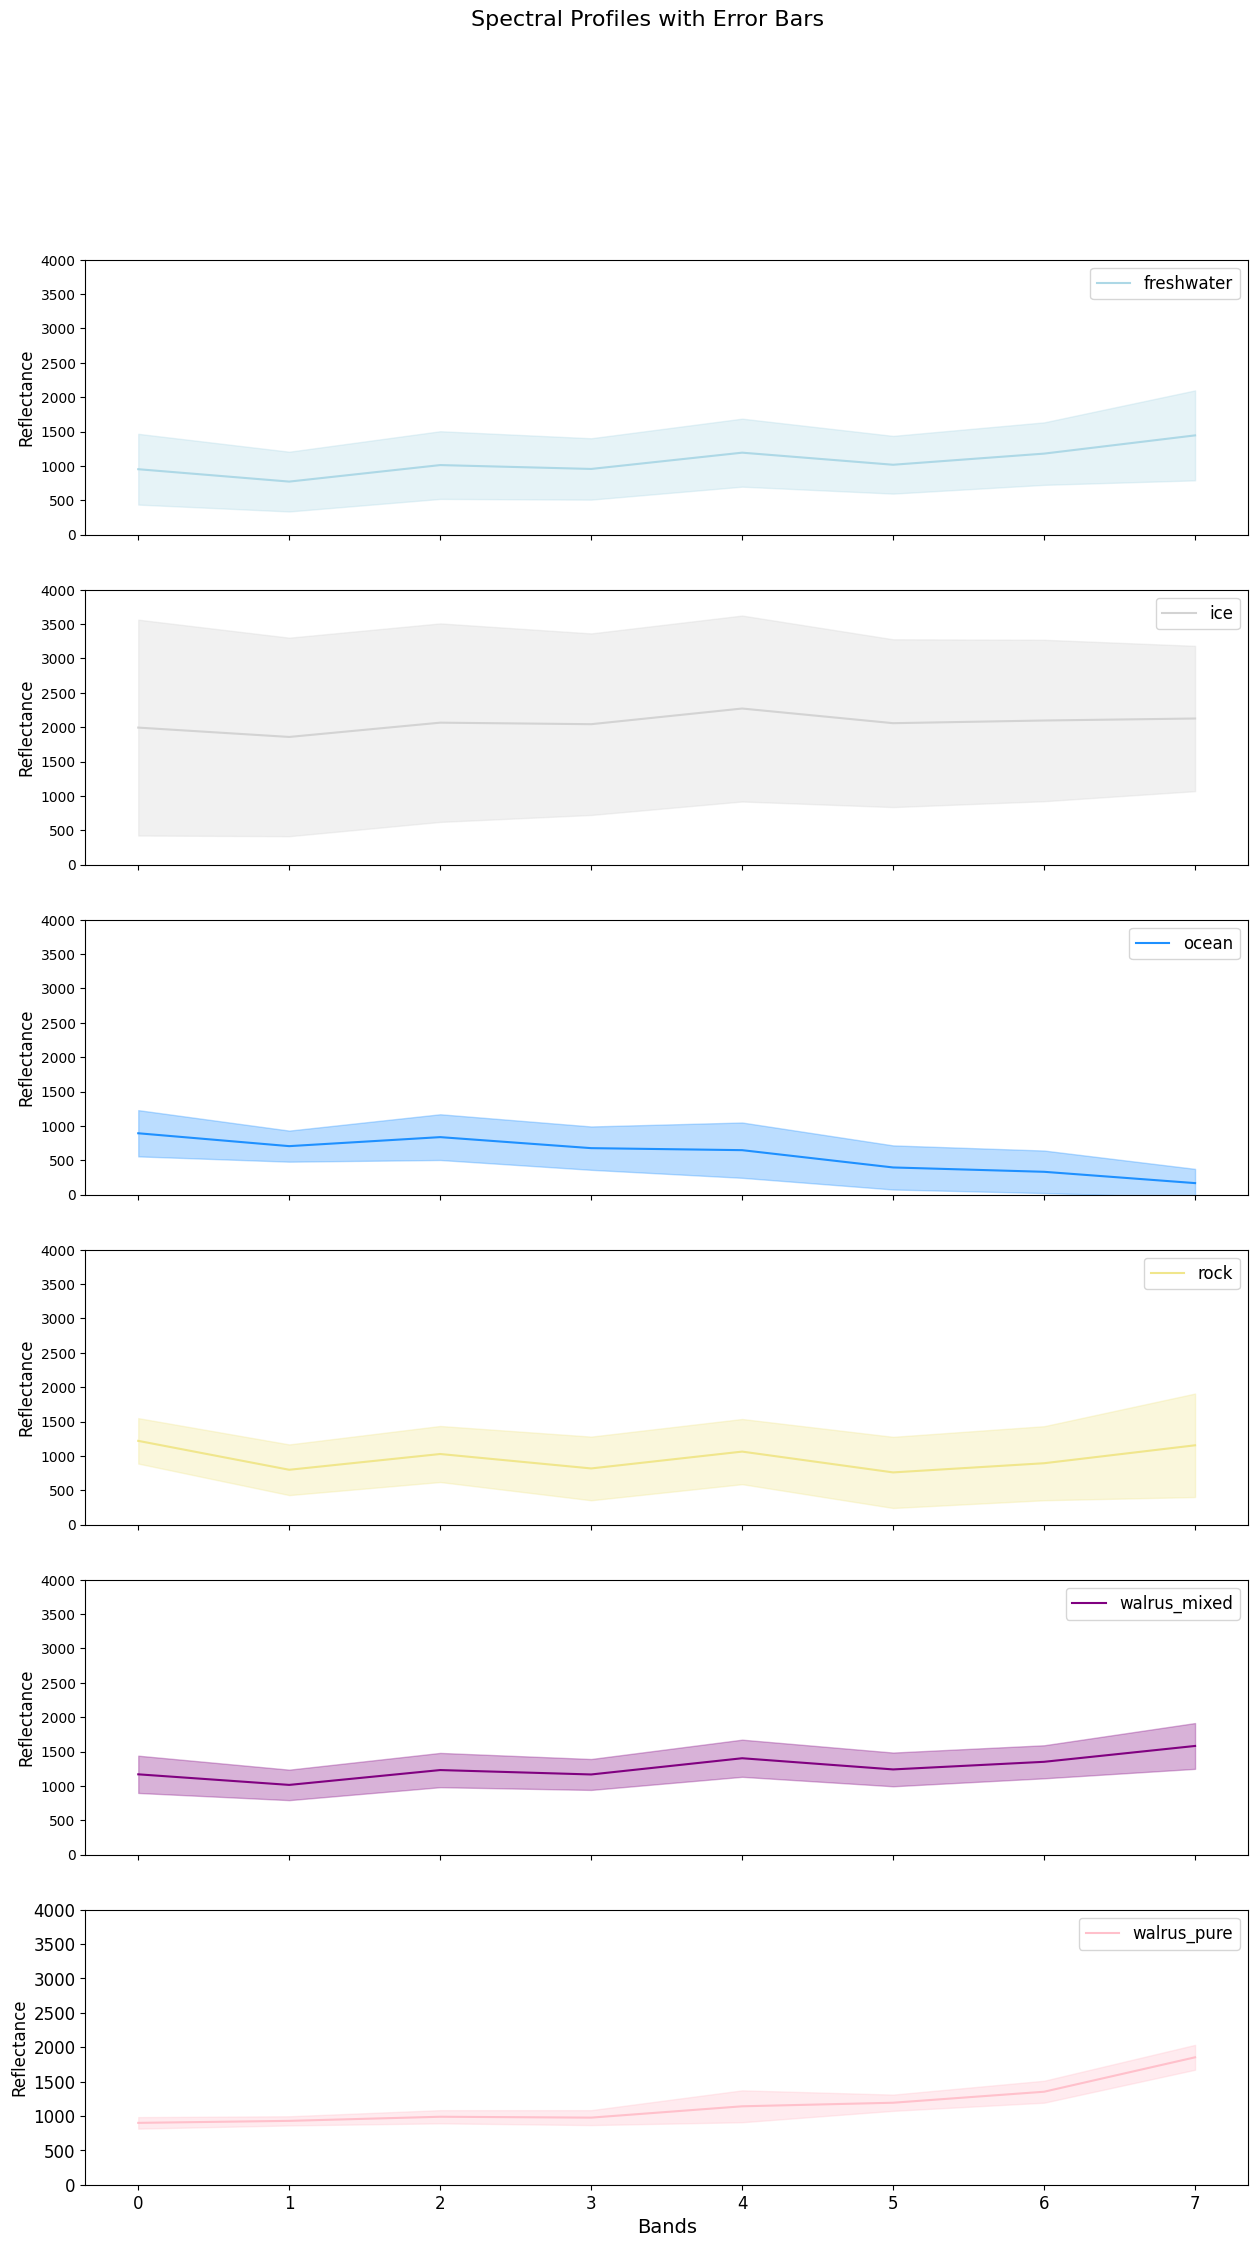

In [14]:
# Create subplots for each class
fig, axs = plt.subplots(len(unique_labels), 1, figsize=(15, 25), sharex=True)

bands = np.arange(features.shape[1])

for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    axs[class_index].plot(bands, mean, label=class_label, color=colors.get(class_label, 'black'))
    axs[class_index].fill_between(bands, mean - std, mean + std, color=colors.get(class_label, 'black'), alpha=0.3)
    axs[class_index].set_ylim([0, 4000])
    axs[class_index].set_ylabel('Reflectance', fontsize=12)
    axs[class_index].legend(fontsize=12)
    axs[class_index].grid(False)

plt.xlabel('Bands', fontsize=14)
plt.suptitle('Spectral Profiles with Error Bars', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

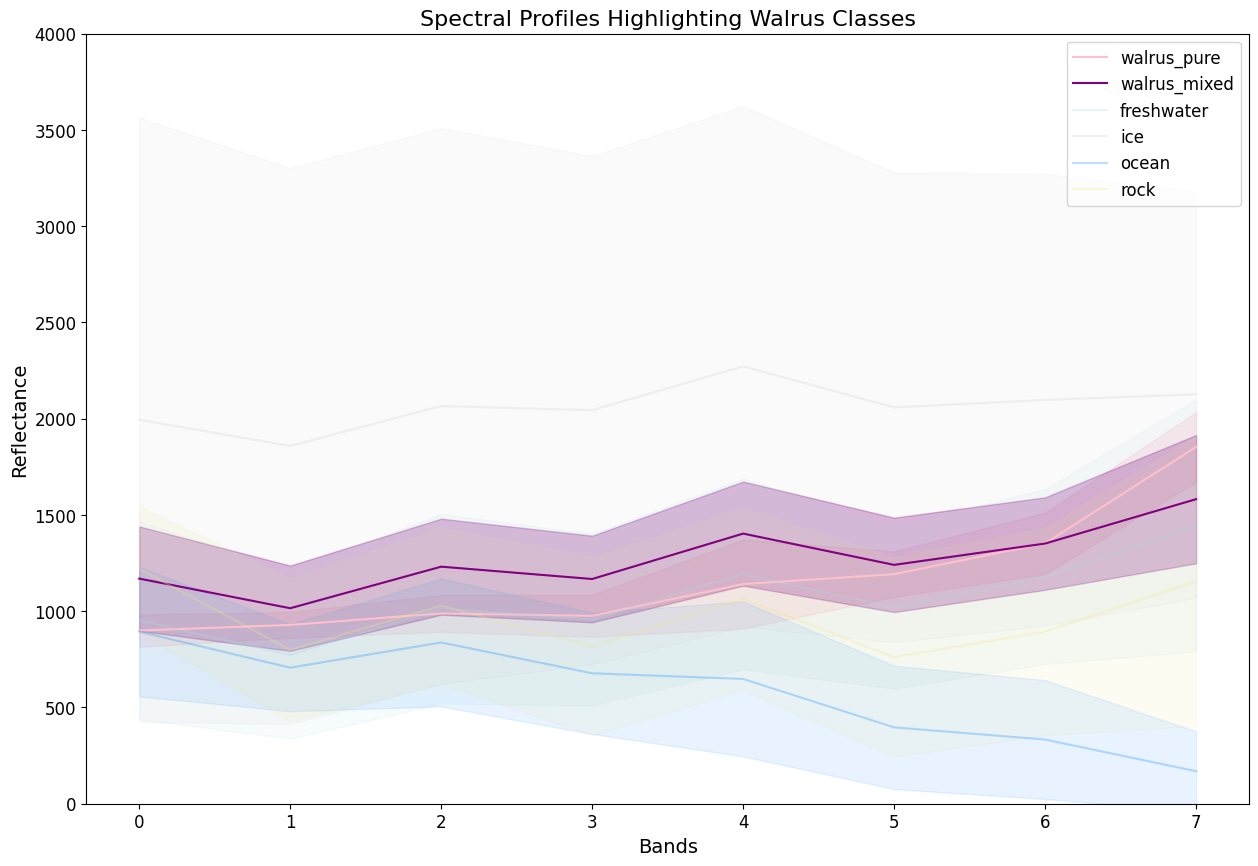

In [15]:
# Highlight "walrus_pure" and "walrus_mixed" against others

plt.figure(figsize=(15, 10))

# Plot "walrus_pure" and "walrus_mixed"
for class_label in ['walrus_pure', 'walrus_mixed']:
    class_index = np.where(unique_labels == class_label)[0][0]
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    plt.plot(bands, mean, label=class_label, color=colors.get(class_label, 'black'))
    plt.fill_between(bands, mean - std, mean + std, color=colors.get(class_label, 'black'), alpha=0.3)

# Plot other classes with lower opacity
for class_index, class_label in enumerate(unique_labels):
    if class_label not in ['walrus_pure', 'walrus_mixed']:
        mean = mean_profiles[class_index]
        std = std_profiles[class_index]
        plt.plot(bands, mean, label=class_label, color=colors.get(class_label, 'black'), alpha=0.3)
        plt.fill_between(bands, mean - std, mean + std, color=colors.get(class_label, 'black'), alpha=0.1)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles Highlighting Walrus Classes', fontsize=16)
plt.legend(fontsize=12)
plt.grid(False)
plt.ylim([0, 4000])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

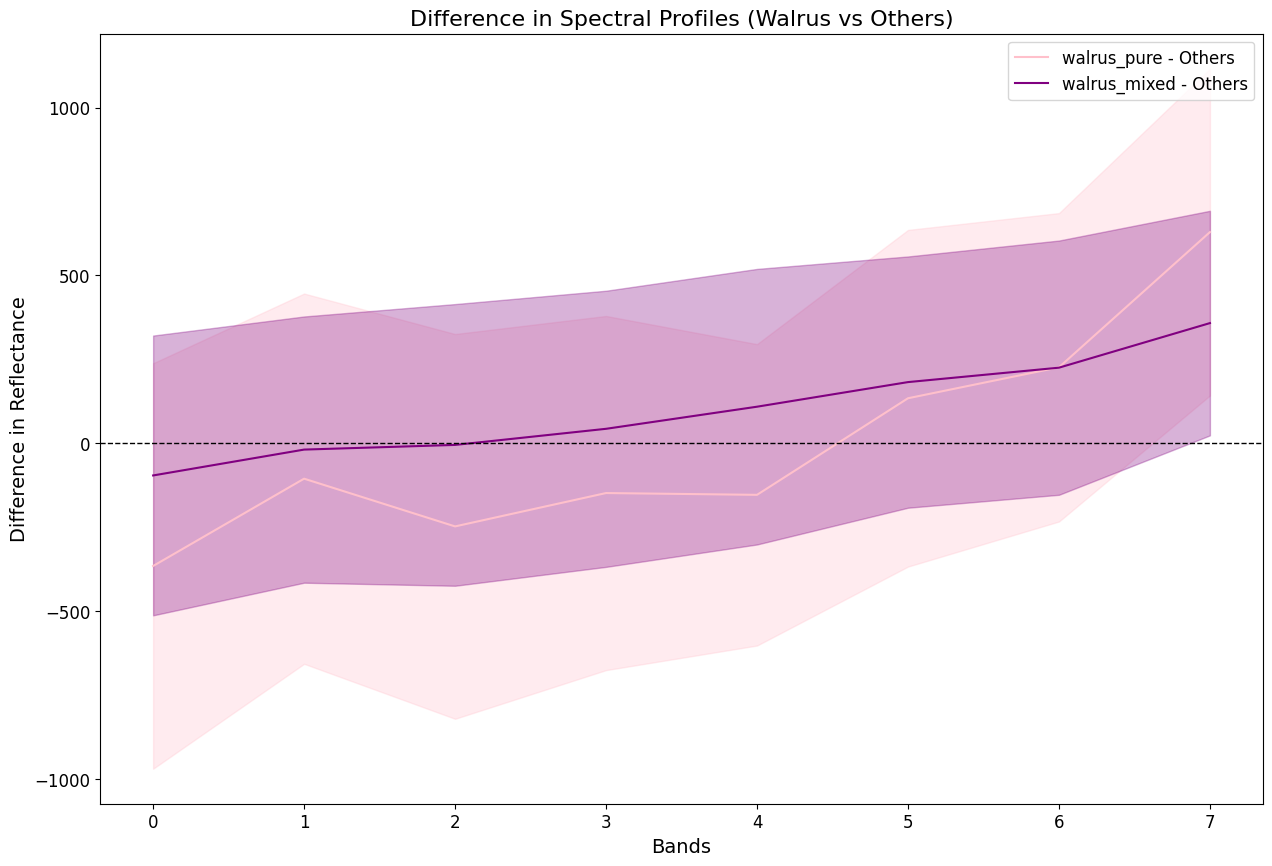

In [17]:
# Calculate the average profile of all other classes (excluding walrus_pure and walrus_mixed)
other_classes = [class_label for class_label in unique_labels if class_label not in ['walrus_pure', 'walrus_mixed']]
other_indices = [np.where(unique_labels == class_label)[0][0] for class_label in other_classes]

mean_other_profiles = np.mean(mean_profiles[other_indices], axis=0)
std_other_profiles = np.mean(std_profiles[other_indices], axis=0)

# Plot the differences
plt.figure(figsize=(15, 10))

for class_label in ['walrus_pure', 'walrus_mixed']:
    class_index = np.where(unique_labels == class_label)[0][0]
    mean_diff = mean_profiles[class_index] - mean_other_profiles
    std_diff = std_profiles[class_index] - std_other_profiles
    plt.plot(bands, mean_diff, label=f'{class_label} - Others', color=colors.get(class_label, 'black'))
    plt.fill_between(bands, mean_diff - std_diff, mean_diff + std_diff, color=colors.get(class_label, 'black'), alpha=0.3)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Difference in Reflectance', fontsize=14)
plt.title('Difference in Spectral Profiles (Walrus vs Others)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [32]:
import rasterio
from rasterio import features
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib
import glob
import pandas as pd
import os
import re
from skimage import exposure
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

In [ ]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [81]:
# Define a dictionary to map labels to numeric identifiers
label_mapping = {
    'walrus_pure': 1,
    'walrus_mixed': 2,
    'ocean': 3,
    'freshwater': 4,
    'ice': 5,
    'rock': 6, 
    'stain': 7
    
}

In [82]:
# Define the function to process the image and shapefile pair
def process_files(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)

    # Map labels to numeric identifiers
    shp_df['label'] = shp_df['label'].map(label_mapping)

    # Print unique labels after mapping
    print(f"Processing {tif_file} and {shp_file}")
    print("Unique labels after mapping:", shp_df['label'].unique())

    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    return out_arr, mask

# Process each pair of files
for key, (image_path, shapefile_path) in file_pairs.items():
    out_arr, mask = process_files(image_path, shapefile_path)

Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
Unique labels after mapping: [1 3 4 5 6]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230720_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
Unique labels after mapping: [2 3 4 6 5]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230731_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230731_train.shp
Unique labels after mapping: [2 3 6 4 5]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230923_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230923_train.shp
Unique labels after mapping: [3 5 6 4]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\moff_20230717_image.tif and C:\Users\Student\Documents\101_

In [79]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create dictionaries to store the image and shapefile paths with their keys
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths}

# Create a dictionary to store paired image and shapefile paths
file_pairs = {key: (image_data[key], shapefile_data[key]) for key in image_data if key in shapefile_data}

# Define the function to process the image and shapefile pair
def process_files(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)

    # Print unique labels before conversion
    print(f"Processing {tif_file} and {shp_file}")
    print("Unique labels before conversion:", shp_df['label'].unique())

    # Convert 'label' field to numeric, handling non-numeric values
    shp_df['label'] = pd.to_numeric(shp_df['label'], errors='coerce')

    # Print unique labels after conversion to numeric but before filling NaNs
    print("Unique labels after conversion to numeric (with NaNs):", shp_df['label'].unique())

    # Fill NaNs with 0 and convert to integer
    shp_df['label'] = shp_df['label'].fillna(0).astype(int)

    # Print unique labels after filling NaNs and converting to integers
    print("Unique labels after filling NaNs and converting to integers:", shp_df['label'].unique())

    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    return out_arr, mask

# Process each pair of files
for key, (image_path, shapefile_path) in file_pairs.items():
    out_arr, mask = process_files(image_path, shapefile_path)
    # Optionally save or further process out_arr and mask


Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
Unique labels before conversion: ['walrus_pure' 'ocean' 'freshwater' 'ice' 'rock']
Unique labels after conversion to numeric (with NaNs): [nan]
Unique labels after filling NaNs and converting to integers: [0]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230720_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
Unique labels before conversion: ['walrus_mixed' 'ocean' 'freshwater' 'rock' 'ice']
Unique labels after conversion to numeric (with NaNs): [nan]
Unique labels after filling NaNs and converting to integers: [0]
Processing C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230731_image.tif and C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230731_train.shp
Unique labels before conversion: ['walrus_mixed

In [77]:
def get_raster_and_mask(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)

    # Print unique labels before conversion
    print(f"Processing {tif_file} and {shp_file}")
    print("Unique labels before conversion:", shp_df['label'].unique())

    # Convert 'label' field to numeric, handling non-numeric values
    shp_df['label'] = pd.to_numeric(shp_df['label'], errors='coerce')

    # Print unique labels after conversion to numeric but before filling NaNs
    print("Unique labels after conversion to numeric (with NaNs):", shp_df['label'].unique())

    # Fill NaNs with 0 and convert to integer
    shp_df['label'] = shp_df['label'].fillna(0).astype(int)

    # Print unique labels after filling NaNs and converting to integers
    print("Unique labels after filling NaNs and converting to integers:", shp_df['label'].unique())

    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    return out_arr, mask


In [34]:
# Specify the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [35]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [76]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Extract island name and date, and match files
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths}

# Prepare training data
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")

for (image_island, image_date), image_path in image_data.items():
    if (image_island, image_date) in shapefile_data:
        file_pairs[image_path] = shapefile_data[(image_island, image_date)]

print("Paired file paths:", file_pairs)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
We have 0 samples
The training data includes 0 classes: []
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 

0 samples? trying to debug below, worked fine before, very confused

In [37]:
import rasterio
from rasterio import features
import geopandas as gpd
import numpy as np
import pandas as pd
import glob
import os
import re

def get_raster_and_mask(tif_file, shp_file):
    # Load shapefile and check contents
    shp_df = gpd.read_file(shp_file)
    print(f"Loaded shapefile: {shp_file}")
    print(shp_df.head())  # Print first few rows of the shapefile
    
    # Open raster file and check CRS
    rstr = rasterio.open(tif_file)
    print(f"Loaded raster: {tif_file} with CRS {rstr.crs}")
    
    # Ensure shapefile CRS matches raster CRS
    if shp_df.crs != rstr.crs:
        print("CRS mismatch, reprojecting shapefile...")
        shp_df = shp_df.to_crs(rstr.crs)
    
    # Convert 'label' field to numeric, handling non-numeric values
    shp_df['label'] = pd.to_numeric(shp_df['label'], errors='coerce').fillna(0).astype(int)
    print(shp_df['label'].value_counts())  # Print label distribution
    
    # Read the raster data as an array
    out_arr = rstr.read()
    
    # Rasterize the shapefile geometries into a mask
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    
    print("Mask unique values and counts:", np.unique(mask, return_counts=True))  # Print unique values in mask
    
    return out_arr, mask

# Specify the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Extract island name and date, and match files
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths}

# Prepare training data
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")

for (image_island, image_date), image_path in image_data.items():
    if (image_island, image_date) in shapefile_data:
        file_pairs[image_path] = shapefile_data[(image_island, image_date)]

print("Paired file paths:", file_pairs)


Loaded shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
   Id        label                                           geometry
0   0  walrus_pure  POLYGON ((506954.882 8736869.728, 506957.199 8...
1   0        ocean  POLYGON ((507675.484 8738207.362, 508285.009 8...
2   0        ocean  POLYGON ((507321.771 8737318.426, 507908.398 8...
3   0        ocean  POLYGON ((508233.977 8736192.130, 508447.055 8...
4   0   freshwater  POLYGON ((507727.552 8735966.696, 507768.275 8...
Loaded raster: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif with CRS EPSG:32634
label
0    19
Name: count, dtype: int64
Mask unique values and counts: (array([0], dtype=uint8), array([1240995], dtype=int64))
We have 0 samples
The training data includes 0 classes: []
Loaded shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230720_train.shp
   Id         label                                           geometry
0   0

In [38]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

def process_shapefile_raster_pair(shapefile_path, raster_path):
    print(f"Processing shapefile: {shapefile_path}")
    print(f"Processing raster: {raster_path}")

    # Read the shapefile
    shapefile = gpd.read_file(shapefile_path)
    

    # Define a mapping of labels to integers
    label_mapping = {
        "ice": 1,
        "ocean": 2,
        "freshwater": 3,
        "rock": 4,
        "stain": 5, 
        "walrus_pure": 6, 
        "Walrus_mixed" : 7
    }

    # Map the labels to integers
    shapefile['label'] = shapefile['label'].map(label_mapping)

    # Read the raster
    with rasterio.open(raster_path) as raster:
        raster_crs = raster.crs
        raster_transform = raster.transform
        raster_shape = raster.shape

    print(f"Loaded shapefile: {shapefile_path}")
    print(shapefile.head())
    print(f"Loaded raster: {raster_path} with CRS {raster_crs}")

    # Rasterize shapefile
    shapes = [(geom, value) for geom, value in zip(shapefile.geometry, shapefile['label'])]
    mask = rasterize(
        shapes,
        out_shape=raster_shape,
        transform=raster_transform,
        fill=0,
        dtype=np.uint8
    )

    # Count unique values in the mask
    unique, counts = np.unique(mask, return_counts=True)
    print(f"Unique values in the mask: {unique}")

    return mask, unique

# Example usage
shapefile_path = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230714_train.shp"
raster_path = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230714_image.tif"
mask, unique = process_shapefile_raster_pair(shapefile_path, raster_path)


Processing shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
Processing raster: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif
Loaded shapefile: C:\Users\Student\Documents\101_walrus_data\train\shapefile\buch_20230714_train.shp
   Id  label                                           geometry
0   0      6  POLYGON ((506954.882 8736869.728, 506957.199 8...
1   0      2  POLYGON ((507675.484 8738207.362, 508285.009 8...
2   0      2  POLYGON ((507321.771 8737318.426, 507908.398 8...
3   0      2  POLYGON ((508233.977 8736192.130, 508447.055 8...
4   0      3  POLYGON ((507727.552 8735966.696, 507768.275 8...
Loaded raster: C:\Users\Student\Documents\101_walrus_data\train\images\buch_20230714_image.tif with CRS EPSG:32634
Unique values in the mask: [0 1 2 3 4 6]


In [39]:
for (image_island, image_date), image_path in image_data.items():
    if (image_island, image_date) in shapefile_data:
        file_pairs[image_path] = shapefile_data[(image_island, image_date)]
    else:
        print(f"Unable to match shapefile for image: {image_path}")


In [40]:
def get_raster_and_mask(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)
    
    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    print("Image shape:", out_arr.shape)
    print("Mask shape:", mask.shape)
    return out_arr, mask


In [41]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Extract island name and date, and match files
image_data = {extract_island_and_date(os.path.basename(image)): image for image in image_paths}
shapefile_data = {extract_island_and_date(os.path.basename(shapefile)): shapefile for shapefile in shapefile_paths
                  
# Prepare training data
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")

for (image_island, image_date), image_path in image_data.items():
    if (image_island, image_date) in shapefile_data:
        file_pairs[image_path] = shapefile_data[(image_island, image_date)]

print("Paired file paths:", file_pairs)

SyntaxError: invalid syntax (805421721.py, line 9)

This bit added from single image test to see if this works

In [42]:
# Initialize lists to store the combined dataset
X_list = []
y_list = []

In [43]:
# Prepare training data
img = img.transpose(1, 2, 0)
n_samples = (roi > 0).sum()
labels = np.unique(roi[roi > 0])
print(f"We have {n_samples} samples")
print(f"The training data includes {labels.size} classes: {labels}")

We have 0 samples
The training data includes 0 classes: []


In [44]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(f"X_train matrix size: {X_train.shape}")
print(f"X_test matrix size: {X_test.shape}")

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=500, oob_score=True)
rf = rf.fit(X_train, y_train)
print(f"Our OOB prediction of accuracy is: {rf.oob_score_ * 100:.2f}%")

# Feature importance
band_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08"]
for b, b_name, imp in zip(range(len(band_names)), band_names, rf.feature_importances_):
    print(f"Band {b} ({b_name}) importance: {imp:.4f}")

X_train matrix size: (287168, 8)
X_test matrix size: (95723, 8)
Our OOB prediction of accuracy is: 99.93%
Band 0 (B01) importance: 0.0040
Band 1 (B02) importance: 0.0397
Band 2 (B03) importance: 0.0809
Band 3 (B04) importance: 0.1559
Band 4 (B05) importance: 0.1820
Band 5 (B06) importance: 0.1725
Band 6 (B07) importance: 0.1910
Band 7 (B08) importance: 0.1740


In [52]:
# Get dimensions and channels of the image
height, width, channels = img.shape
print(f"Dimensions of {filename}: height={height}, width={width}, channels={channels}")

Dimensions of tor_20230902_image_metadata.json: height=1640, width=8, channels=1327


In [48]:
# Plot original image and the predicted classes
img_rgb = colour_stretch(img, [2, 1, 0], (0, 4000))
pred_cmap, patches, c_range = get_prediction_colourmap(class_prediction)

plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title("RGB image")

plt.subplot(122)
plt.imshow(class_prediction, cmap=pred_cmap, vmin=c_range[0], vmax=c_range[1])
plt.legend(handles=patches)
plt.title("Class prediction")
plt.show()


NameError: name 'class_prediction' is not defined

this didnt work - it worked before i am very confused. trying again below. 

In [53]:
# Function for plotting
def make_plotting_array(full_arr, percent_clip=2):
    rgb_arr = np.array([full_arr[2], full_arr[1], full_arr[0]])
    p1, p2 = np.percentile(rgb_arr, (percent_clip, 100-percent_clip))
    rgb_rescale = exposure.rescale_intensity(rgb_arr, in_range=(p1, p2))
    return rgb_rescale.transpose(1, 2, 0)

# Function for plotting
def colour_stretch(image, index, minmax=(0, 10000)):
    colours = image[:, :, index].astype(np.float64)
    max_val = minmax[1]
    min_val = minmax[0]
    
    colours[colours > max_val] = max_val
    colours[colours < min_val] = min_val
    
    for b in range(colours.shape[2]):
        colours[:, :, b] = colours[:, :, b] * 1 / (max_val - min_val)
        
    return colours

In [64]:
# Function to define labels and raster mask
def get_raster_and_mask(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)
# Convert 'label' field to numeric, handling non-numeric values
    shp_df['label'] = pd.to_numeric(shp_df['label'], errors='coerce').fillna(0).astype(int)
    
    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    return out_arr, mask

In [65]:
# Funciton for plotting 
def get_prediction_colourmap(pred_array):
    labels = {0: "ice", 1: "ocean", 2: "freshwater", 3: "rock", 4: "stain", 5: "walrus_pure", 6: "walrus_mixed"}
    cmap = {0: "blue", 1: "lightskyblue", 2: "green", 3: "gray", 4: "brown", 5: "red", 6: "purple"}
    patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
    cmap = ListedColormap(cmap.values())
    colour_range = (min(labels), max(labels))
    return cmap, patches, colour_range 

In [66]:
# Specify the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [72]:
# Iterate through all files in the images directory
for image_file in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(image_file)
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_file}")
        continue
        
    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_file}")
        continue    
    
    # Assuming there's only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]    
    
    # Get raster and mask for the image
    img, roi = get_raster_and_mask(image_file, shapefile_path)

In [73]:
# Prepare training data
img = img.transpose(1, 2, 0)
n_samples = (roi > 0).sum()
labels = np.unique(roi[roi > 0])
print(f"We have {n_samples} samples for {image_file}")
print(f"The training data includes {labels.size} classes: {labels}")

We have 0 samples for C:\Users\Student\Documents\101_walrus_data\train\images\tor_20230902_image.tif
The training data includes 0 classes: []


In [74]:
# Prepare the training data
X = img[roi > 0, :]
y = roi[roi > 0]

In [75]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(f"X_train matrix size: {X_train.shape}")
print(f"X_test matrix size: {X_test.shape}")

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

DriverError: C:\Users\Student\Documents\101_walrus_data\train\shapefile\tor_20230902_image.shp: No such file or directory

In [21]:

# Load the existing model if it exists, else create a new one
try:
    rf = joblib.load('random_forest_model.pkl')
    print("Loaded existing model.")
except FileNotFoundError:
    rf = RandomForestClassifier(n_estimators=500, oob_score=True)
    print("No existing model found. Created a new one.")

Loaded existing model.


In [25]:
def get_raster_and_mask(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)
    
    # Map string labels to numerical values dynamically
    labels = {label: index + 1 for index, label in enumerate(shp_df['label'].unique())}
    shp_df['label'] = shp_df['label'].map(labels)
    
    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    return out_arr, mask


In [26]:
# Double check the shapefiles all have the same column names to avoid further issues 

import fiona

# Iterate through shapefile paths
for shapefile_path in shapefile_paths:
    # Open the shapefile
    with fiona.open(shapefile_path) as shp:
        # Print the column names
        print(f"Shapefile: {shapefile_path}")
        print("Column names:", shp.schema['properties'].keys())
        print()


Shapefile: C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\buch_20230714_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\buch_20230720_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\buch_20230731_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\buch_20230923_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\moff_20230717_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\pal_20230714_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\pal_20230720_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefil

In [27]:
# Define functions for visualization
def make_plotting_array(full_arr, percent_clip=2):
    rgb_arr = np.array([full_arr[2], full_arr[1], full_arr[0]])
    p1, p2 = np.percentile(rgb_arr, (percent_clip, 100-percent_clip))
    rgb_rescale = exposure.rescale_intensity(rgb_arr, in_range=(p1, p2))
    return rgb_rescale.transpose(1, 2, 0)

def colour_stretch(image, index, minmax=(0, 10000)):
    colours = image[:, :, index].astype(np.float64)
    max_val = minmax[1]
    min_val = minmax[0]
    
    colours[colours > max_val] = max_val
    colours[colours < min_val] = min_val
    
    for b in range(colours.shape[2]):
        colours[:, :, b] = colours[:, :, b] * 1 / (max_val - min_val)
        
    return colours

def get_prediction_colourmap(pred_array):
    labels = {0: "NoData", 1: "ice", 2: "ocean", 3: "freshwater", 4: "rock", 5: "stain", 6: "walrus_pure", 7: "walrus_mixed"}
    cmap = {0: "gray", 1: "lightblue", 2: "blue", 3: "lightgreen", 4: "brown", 5: "purple", 6: "red", 7: "orange"}
    patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
    cmap = ListedColormap(cmap.values())
    colour_range = (min(labels), max(labels))
    return cmap, patches, colour_range


We have 74202 samples
The training data includes 5 classes: [1 2 3 4 5]
We have 145462 samples
The training data includes 5 classes: [1 2 3 4 5]
We have 276991 samples
The training data includes 5 classes: [1 2 3 4 5]
We have 299367 samples
The training data includes 4 classes: [1 2 3 4]
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We have 0 samples
The training data includes 0 classes: []
We 

In [28]:
    # Prepare training data
    img = img.transpose(1, 2, 0)
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")
    

We have 0 samples
The training data includes 0 classes: []


In [29]:
# Process each image and corresponding shapefile
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)  
    
    X = img[roi > 0, :]  # Extract the features
    y = roi[roi > 0]     # Extract the labels
    
    X_list.append(X)
    y_list.append(y)

# Combine all data
X_combined = np.vstack(X_list)
y_combined = np.hstack(y_list)

In [30]:
# Save combined data for future use
combined_data = pd.DataFrame(X_combined)
combined_data['Label'] = y_combined
combined_data.to_csv('combined_data.csv', index=False)

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.25, random_state=0)

# Train the model
rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [29]:
# Save the model
joblib.dump(rf, 'random_forest_model.pkl')
print("Model saved to random_forest_model.pkl")

Model saved to random_forest_model.pkl


In [30]:
# Evaluate the model
print(f"Our OOB prediction of accuracy is: {rf.oob_score_ * 100:.2f}%")

Our OOB prediction of accuracy is: 85.61%


In [67]:
# Loop through each image and its corresponding shapefile
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    
# Predictions
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img.reshape(new_shape)
class_prediction = rf.predict(img_as_array)
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
    
# Visualization
img_rgb = colour_stretch(img, [2, 1, 0], (0, 4000))
pred_cmap, patches, c_range = get_prediction_colourmap(class_prediction)

plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title("RGB image")
plt.subplot(122)
plt.imshow(class_prediction, cmap=pred_cmap, vmin=c_range[0], vmax=c_range[1])
plt.legend(handles=patches)
plt.title("Class prediction")
plt.show()



ValueError: X has 1194 features, but RandomForestClassifier is expecting 8 features as input.

In [31]:
# Print feature importances
feature_importances = rf.feature_importances_
feature_names = [f'Band {i+1}' for i in range(X_combined.shape[1])]
print("Feature Importances:")
for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance:.4f}")

Feature Importances:
Band 1: 0.0242
Band 2: 0.0439
Band 3: 0.0432
Band 4: 0.0680
Band 5: 0.1119
Band 6: 0.1492
Band 7: 0.2930
Band 8: 0.2666


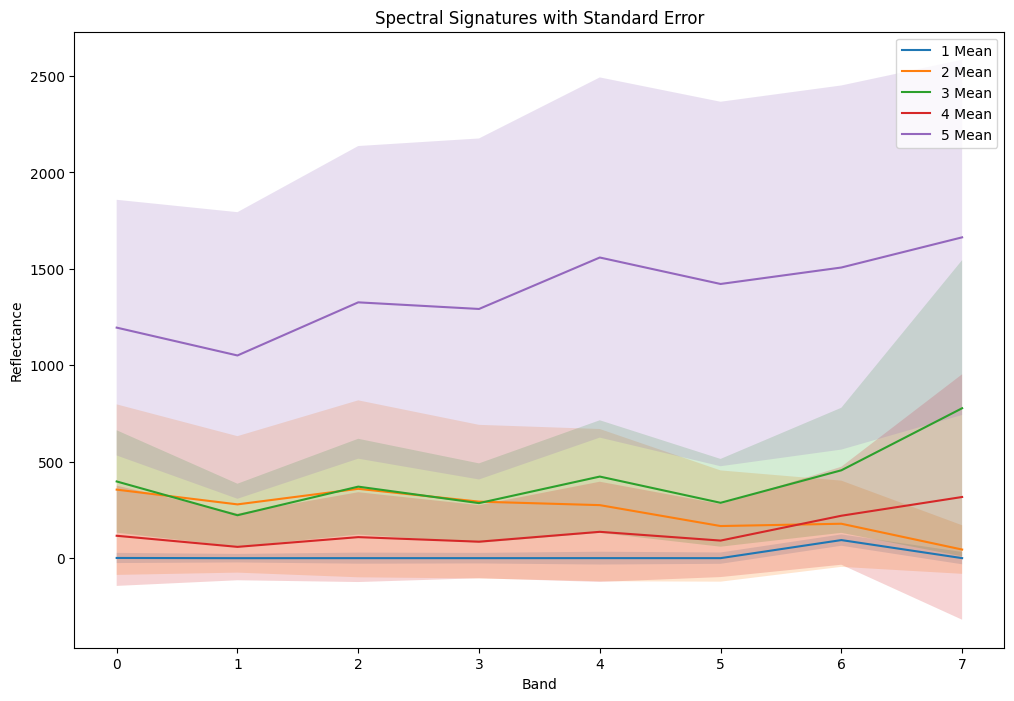

In [32]:
# Plot spectral signatures
def plot_spectral_signatures(data, labels, class_names):
    means = data.groupby(labels).mean()
    stds = data.groupby(labels).std()
    
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(class_names):
        plt.plot(means.columns, means.iloc[i], label=f'{class_name} Mean')
        plt.fill_between(means.columns, means.iloc[i] - stds.iloc[i], means.iloc[i] + stds.iloc[i], alpha=0.2)
    
    plt.xlabel('Band')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.title('Spectral Signatures with Standard Error')
    plt.show()

# Plot the spectral signatures
class_names = np.unique(y_combined)
plot_spectral_signatures(pd.DataFrame(X_combined), y_combined, class_names)




In [44]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import skimage as skm
from skimage import exposure, img_as_float
from rasterio import features
import rasterio
from rasterio import features
import geopandas as gpd
import numpy as np
from skimage import exposure
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import os

In [45]:
# List of image and shapefile pairs
image_shapefile_pairs = [
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230714_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230714_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230720_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230720_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230731_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230731_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\buch_20230923_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\buch_20230923_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\moff_20230717_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\moff_20230717_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pal_20230714_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pal_20230714_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pal_20230720_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pal_20230720_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pal_20230726_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pal_20230726_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pool_20230716_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pool_20230716_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pool_20230803_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pool_20230803_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\pool_20230922_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\pool_20230922_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\sars_20230714_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\sars_20230714_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\sars_20230803_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\sars_20230803_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\tor_20230801_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\tor_20230801_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\tor_20230824_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\tor_20230824_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\tor_20230901_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\tor_20230901_train.shp"),
    ("C:\\Users\\Student\\Documents\\101_walrus_data\\train\\images\\tor_20230902_image.tif", "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\shapefile\\tor_20230902_train.shp")
]

In [46]:
for image_file, shapefile_file in image_shapefile_pairs:
    try:
        # Read image
        with rasterio.open(image_file) as img:
            bands = img.read()
            transform = img.transform
    except rasterio.errors.RasterioIOError:
        print(f"Error: Unable to open file {image_file}")
        continue
    
    # Read shapefile
    try:
        img, roi = get_raster_and_mask(image_file, shapefile_file)
    except Exception as e:
        print(f"Error processing {image_file} and {shapefile_file}: {e}")
        continue
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


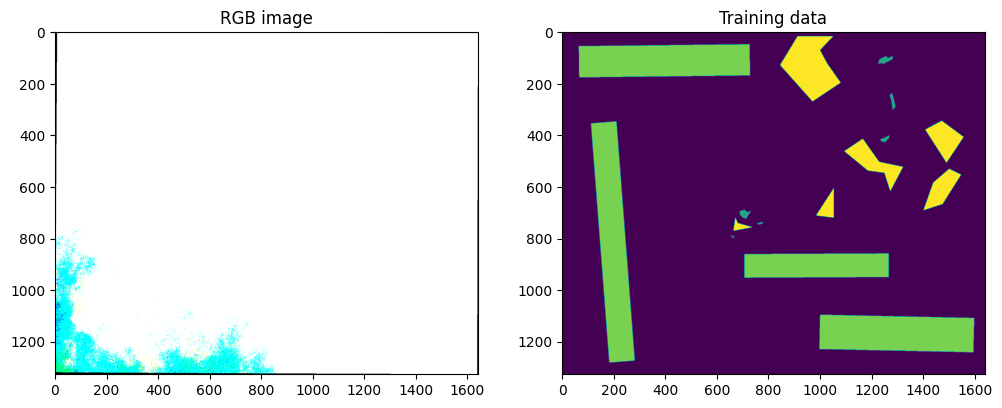

In [49]:
def make_plotting_array(full_arr, percent_clip=2):
    rgb_arr = np.array([full_arr[2], full_arr[1], full_arr[0]])
    p1, p2 = np.percentile(rgb_arr, (percent_clip, 100-percent_clip))
    rgb_rescale = exposure.rescale_intensity(rgb_arr, in_range=(p1, p2))
    return rgb_rescale.transpose(1, 2, 0)
    
# Call make_plotting_array to generate the RGB image array
rgb_image = make_plotting_array(img)

# Visualize image and training data
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(rgb_image)
plt.title("RGB image")
plt.subplot(122)
plt.imshow(roi)
plt.title("Training data")
plt.show() 

In [50]:

    # Prepare training data
    img = img.transpose(1, 2, 0)
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    print(f"We have {n_samples} samples")
    print(f"The training data includes {labels.size} classes: {labels}")
    X = img[roi > 0, :]
    y = roi[roi > 0]

    print(f"X matrix size: {X.shape}")
    print(f"y array size: {y.shape}")
    

We have 382891 samples
The training data includes 5 classes: [1 2 3 4 5]
X matrix size: (382891, 8)
y array size: (382891,)


In [51]:

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    print(f"X_train matrix size: {X_train.shape}")
    print(f"X_test matrix size: {X_test.shape}")

    # Train Random Forest model
    rf = RandomForestClassifier(n_estimators=500, oob_score=True)
    rf = rf.fit(X_train, y_train)
    print(f"Our OOB prediction of accuracy is: {rf.oob_score_ * 100:.2f}%")


X_train matrix size: (287168, 8)
X_test matrix size: (95723, 8)
Our OOB prediction of accuracy is: 99.93%


In [52]:
    # Feature importance
    band_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08"]
    for b, b_name, imp in zip(range(len(band_names)), band_names, rf.feature_importances_):
        print(f"Band {b} ({b_name}) importance: {imp:.4f}")

Band 0 (B01) importance: 0.0038
Band 1 (B02) importance: 0.0450
Band 2 (B03) importance: 0.0923
Band 3 (B04) importance: 0.1957
Band 4 (B05) importance: 0.1763
Band 5 (B06) importance: 0.1618
Band 6 (B07) importance: 0.1528
Band 7 (B08) importance: 0.1722


In [53]:
    # Predictions
    new_shape = (img.shape[0] * img.shape[1], img.shape[2])
    img_as_array = img.reshape(new_shape)
    print(f"Reshaped from {img.shape} to {img_as_array.shape}")
    class_prediction = rf.predict(img_as_array)
    class_prediction = class_prediction.reshape(img[:, :, 0].shape)
    

Reshaped from (1327, 1640, 8) to (2176280, 8)


In [55]:
def colour_stretch(image, index, minmax=(0, 10000)):
    colours = image[:, :, index].astype(np.float64)
    max_val = minmax[1]
    min_val = minmax[0]
    
    colours[colours > max_val] = max_val
    colours[colours < min_val] = min_val
    
    for b in range(colours.shape[2]):
        colours[:, :, b] = colours[:, :, b] * 1 / (max_val - min_val)
        
    return colours

In [57]:
def get_prediction_colourmap(pred_array):
    labels = {0: "NoData", 1: "ocean", 2: "land", 3: "walrus", 4: "ice", 5: "rock", 6: "freshwater", 7: "stain", 8: "walrus_pure", 9: "walrus_mixed"}
    cmap = {0: "gray", 1: "lightskyblue", 2: "green", 3: "red", 4: "blue", 5: "brown", 6: "cyan", 7: "yellow", 8: "purple", 9: "orange"}
    patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
    cmap = ListedColormap(cmap.values())
    colour_range = (min(labels), max(labels))
    return cmap, patches, colour_range


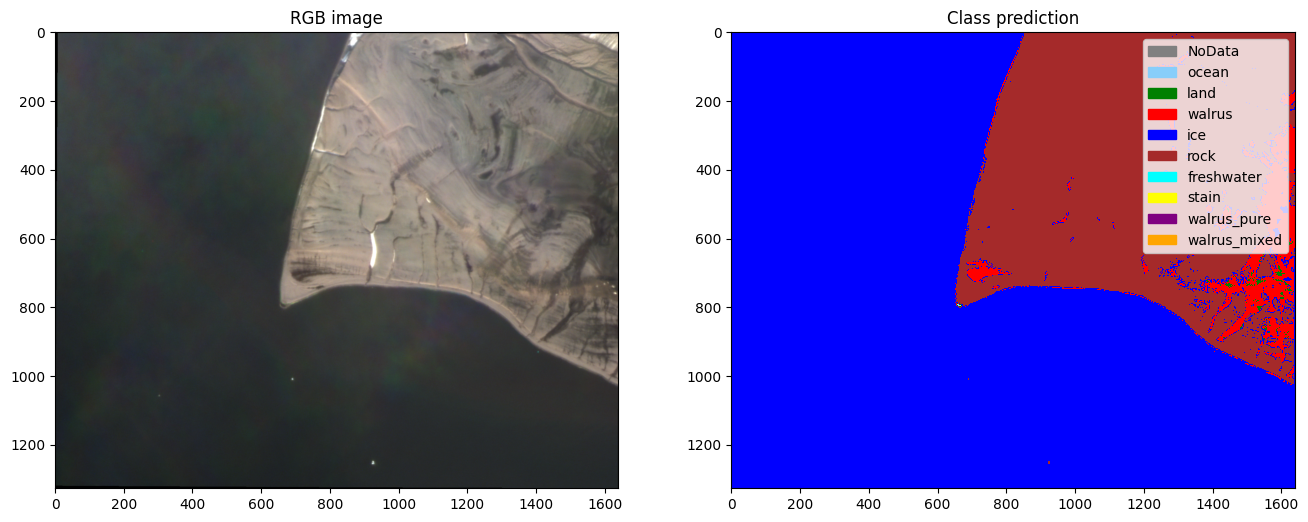

In [58]:

    # Visualization
    img_rgb = colour_stretch(img, [2, 1, 0], (0, 4000))
    pred_cmap, patches, c_range = get_prediction_colourmap(class_prediction)

    plt.figure(figsize=(16, 10))
    plt.subplot(121)
    plt.imshow(img_rgb)
    plt.title("RGB image")

    plt.subplot(122)
    plt.imshow(class_prediction, cmap=pred_cmap, vmin=c_range[0], vmax=c_range[1])
    plt.legend(handles=patches)
    plt.title("Class prediction")
    plt.show()

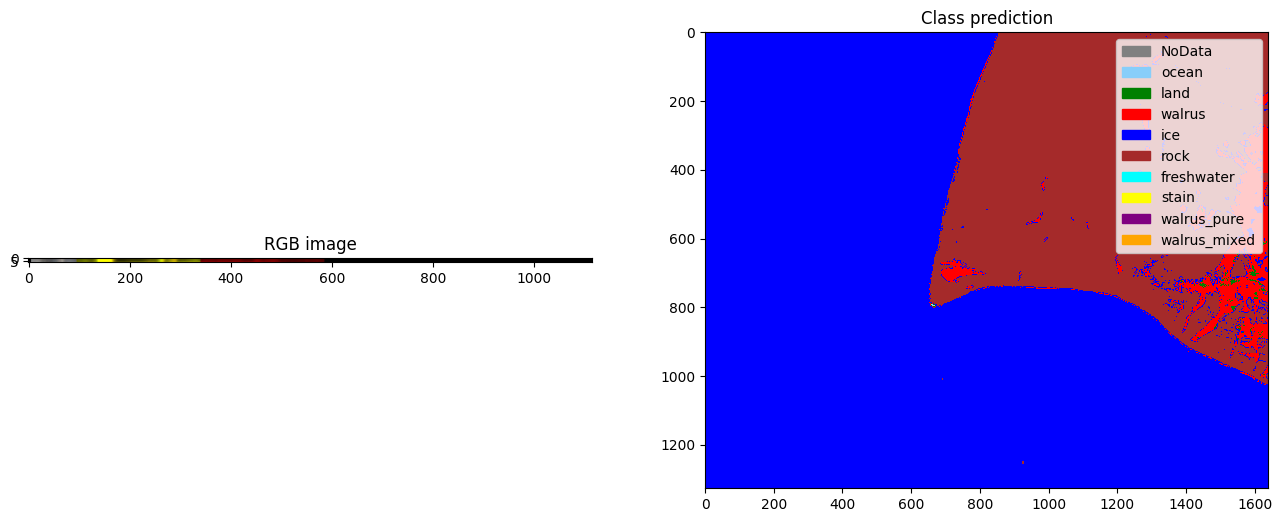

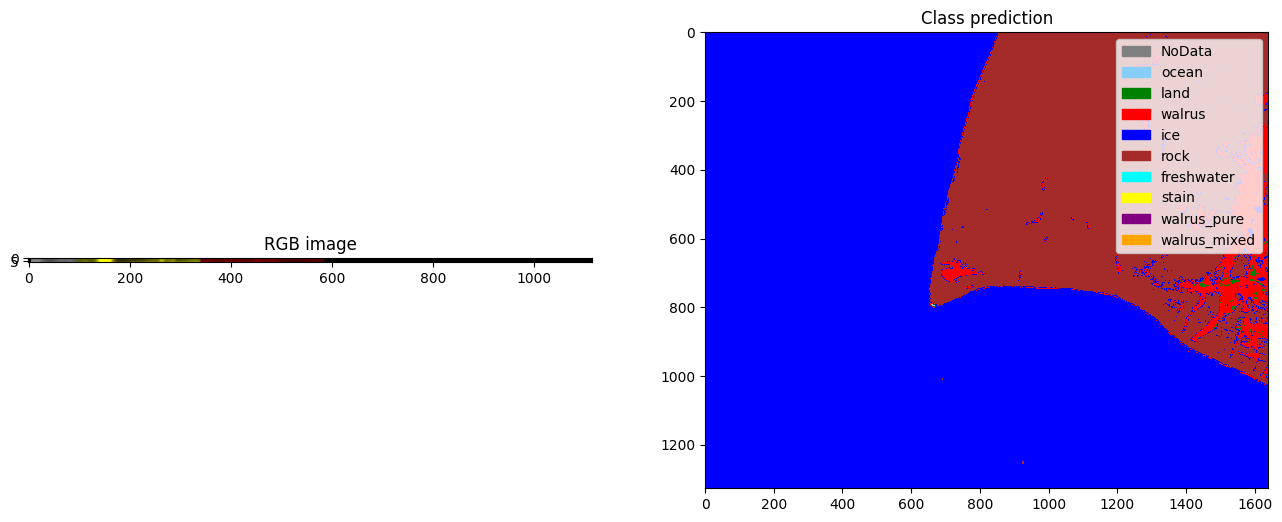

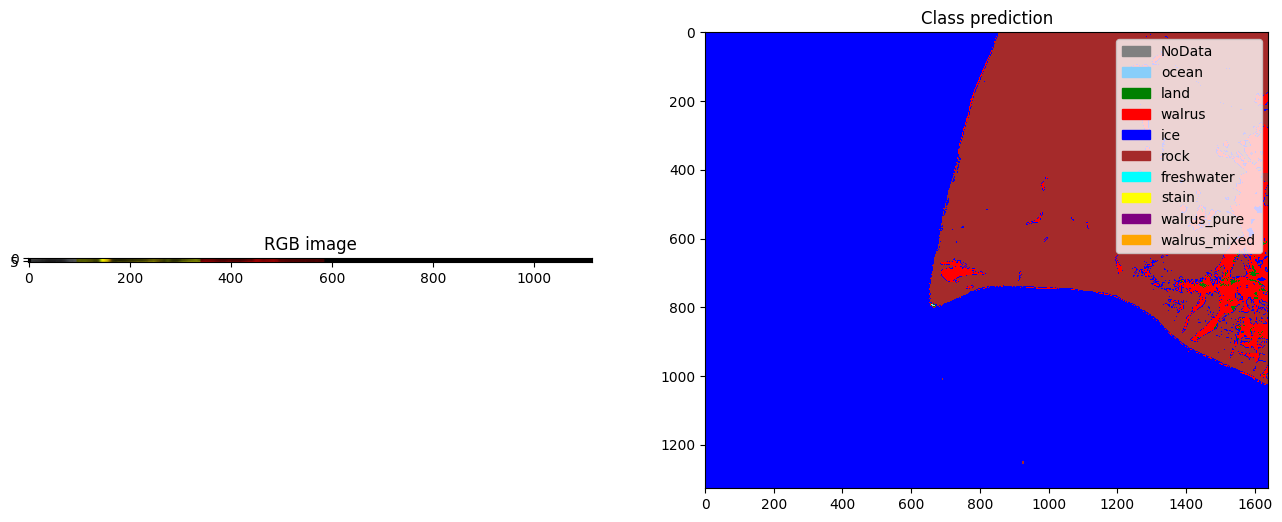

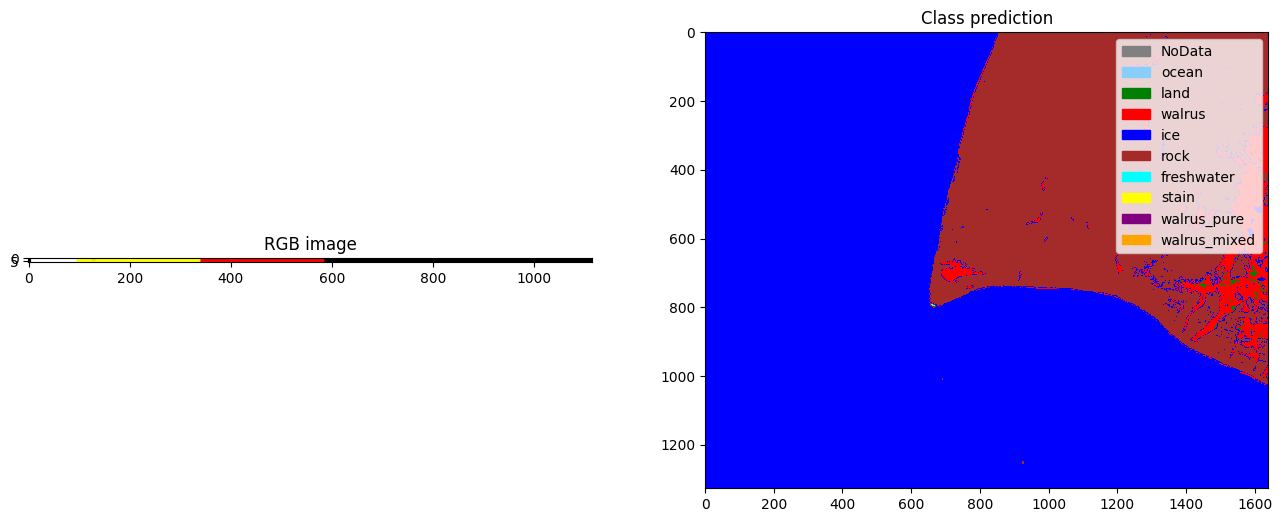

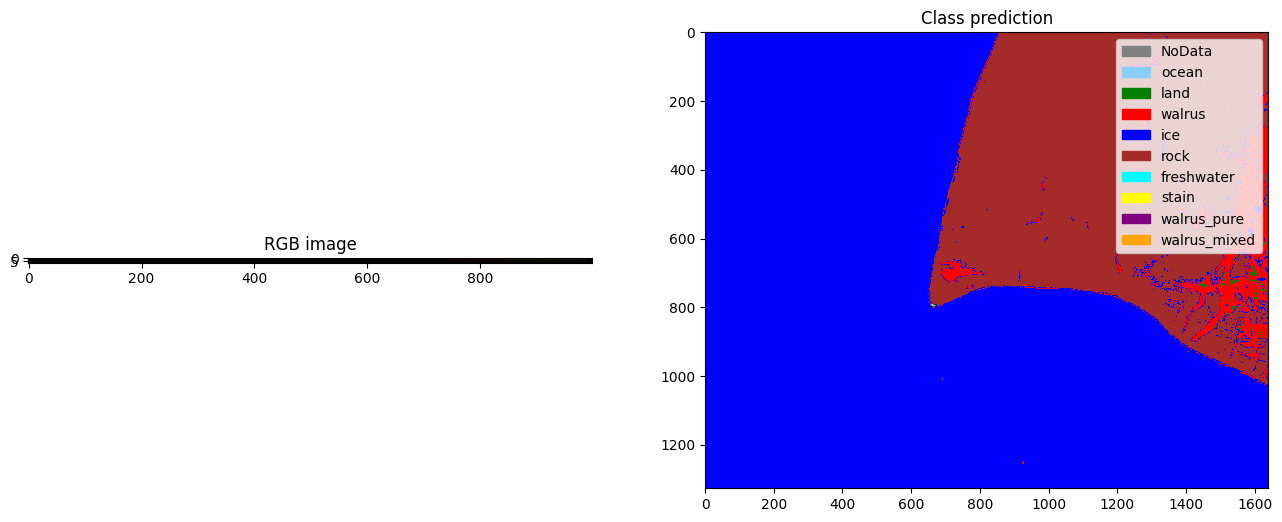

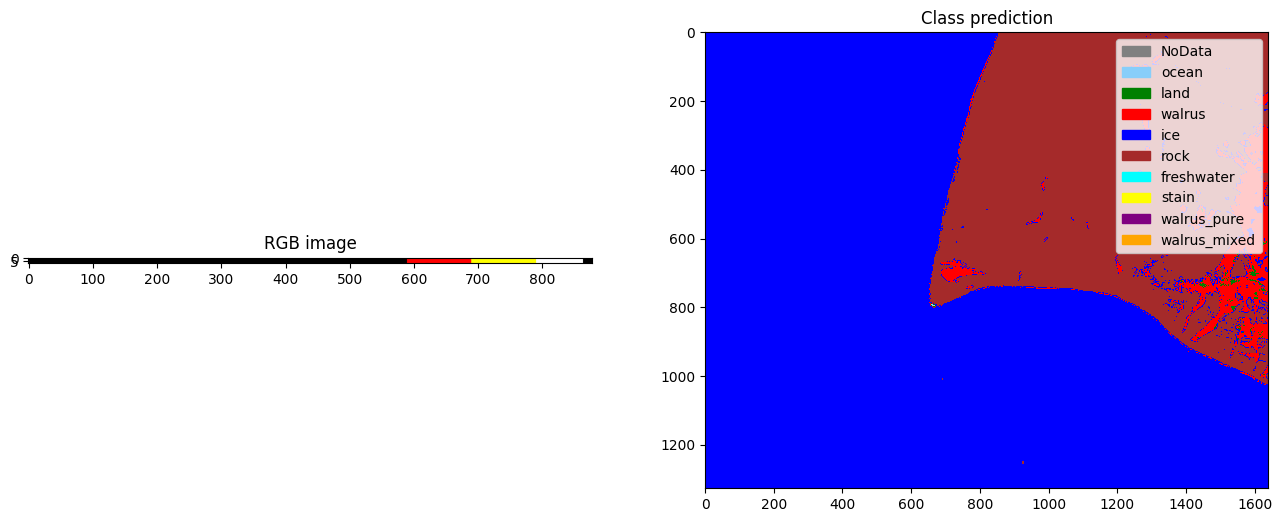

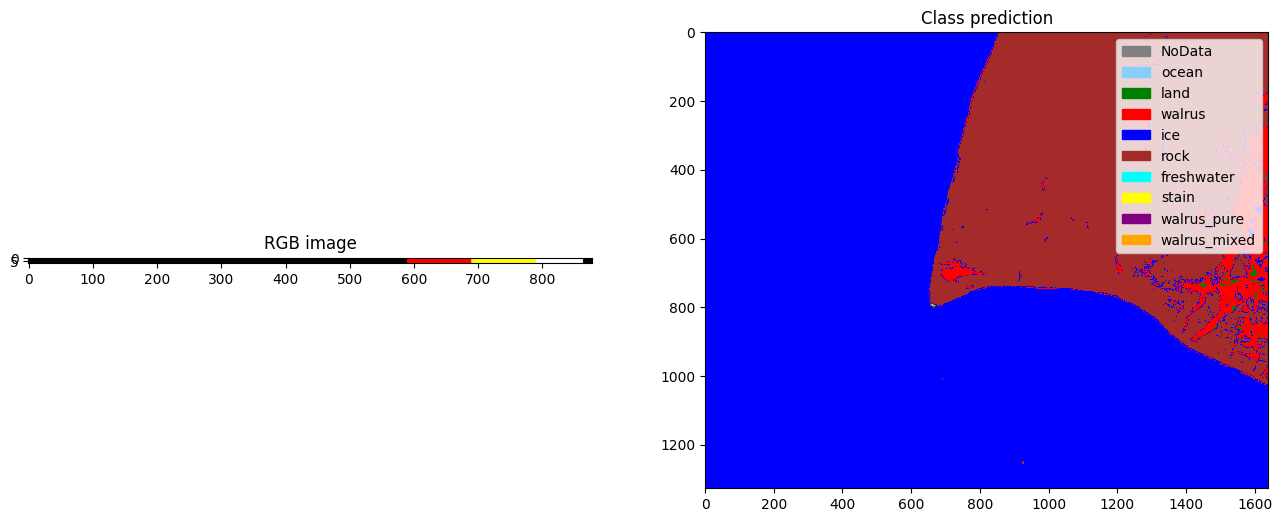

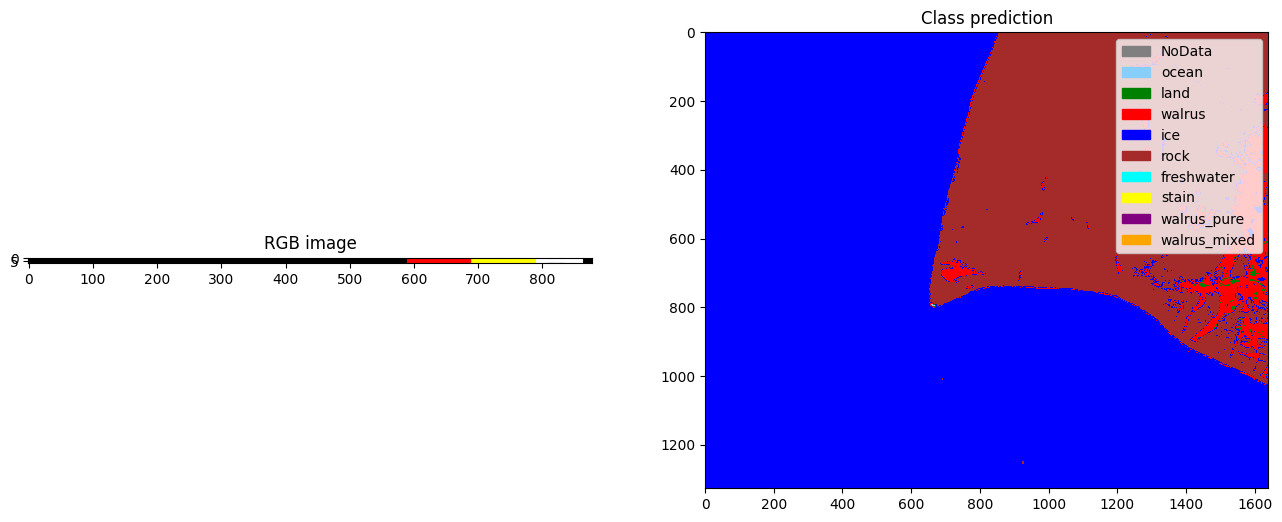

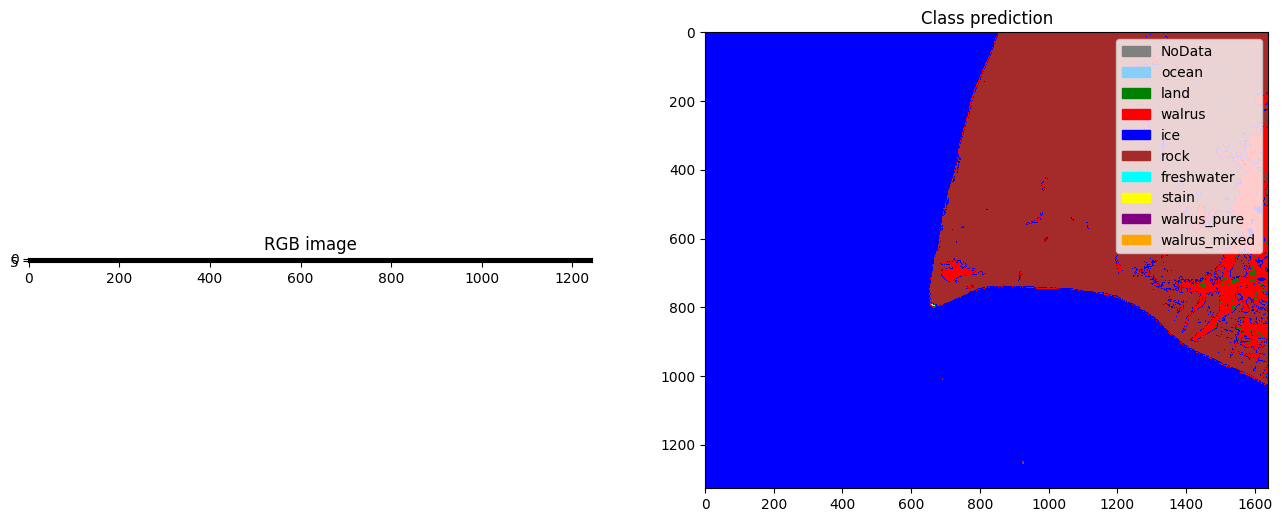

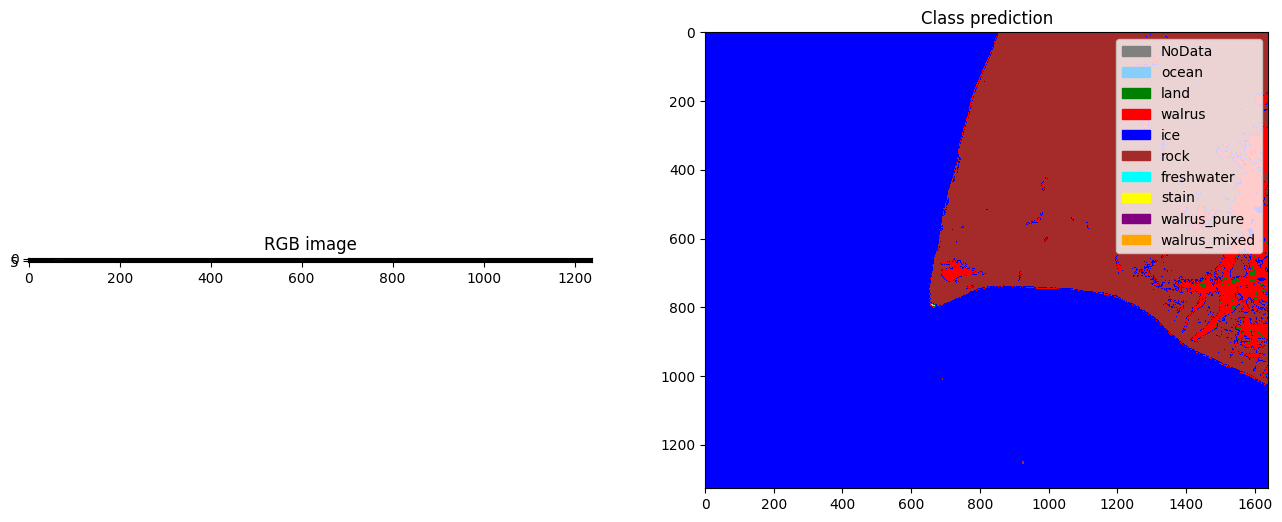

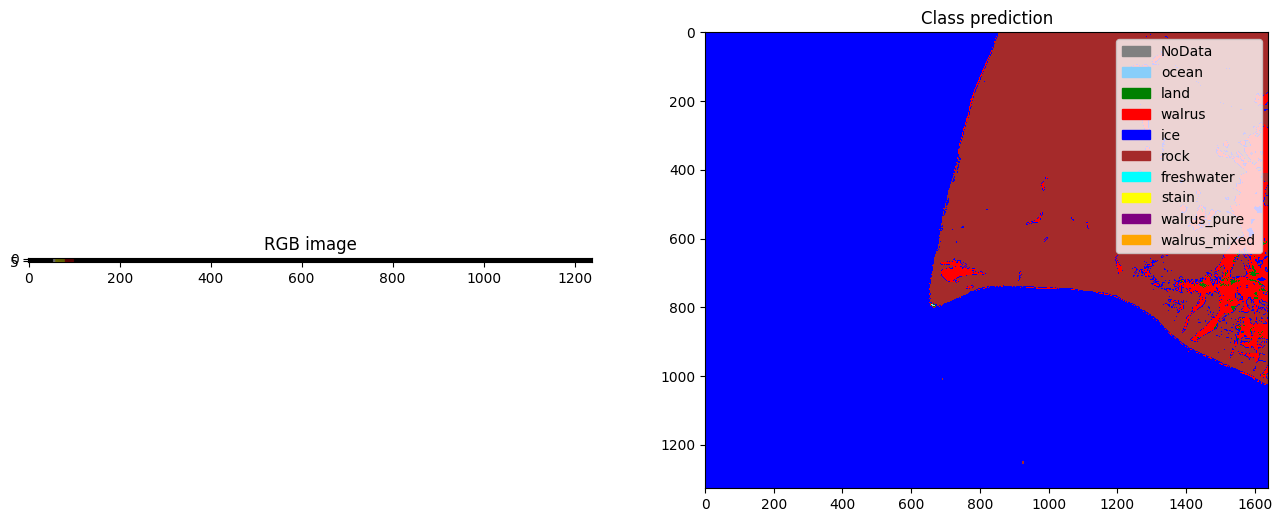

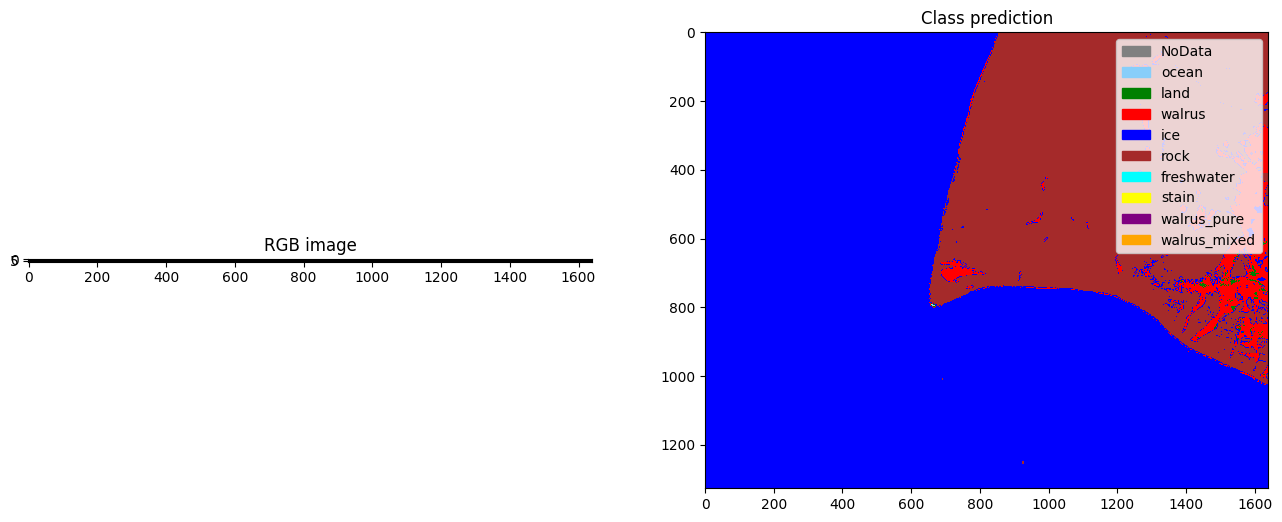

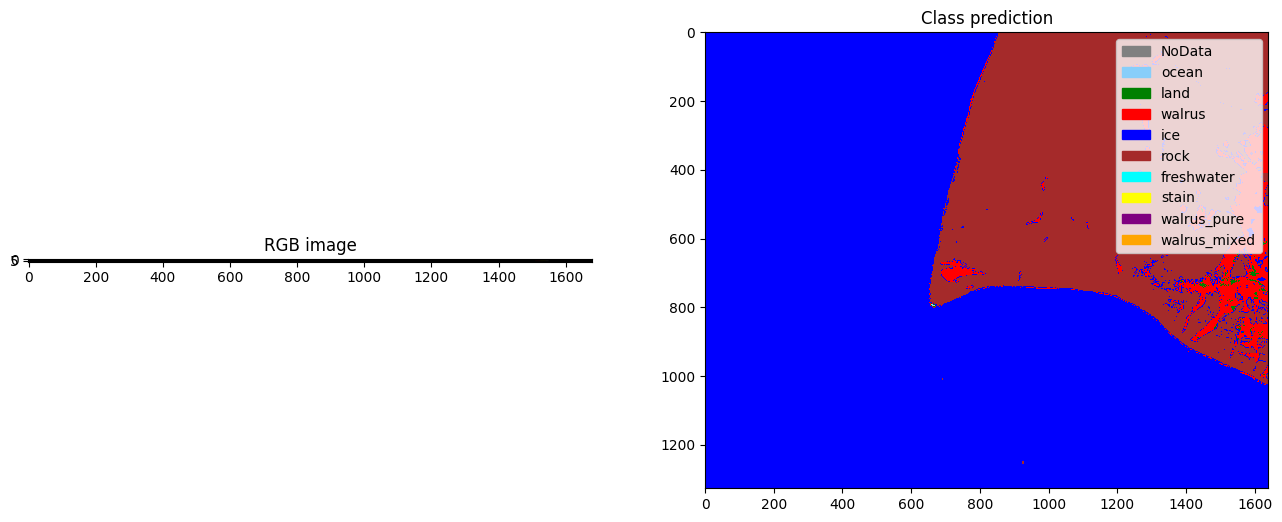

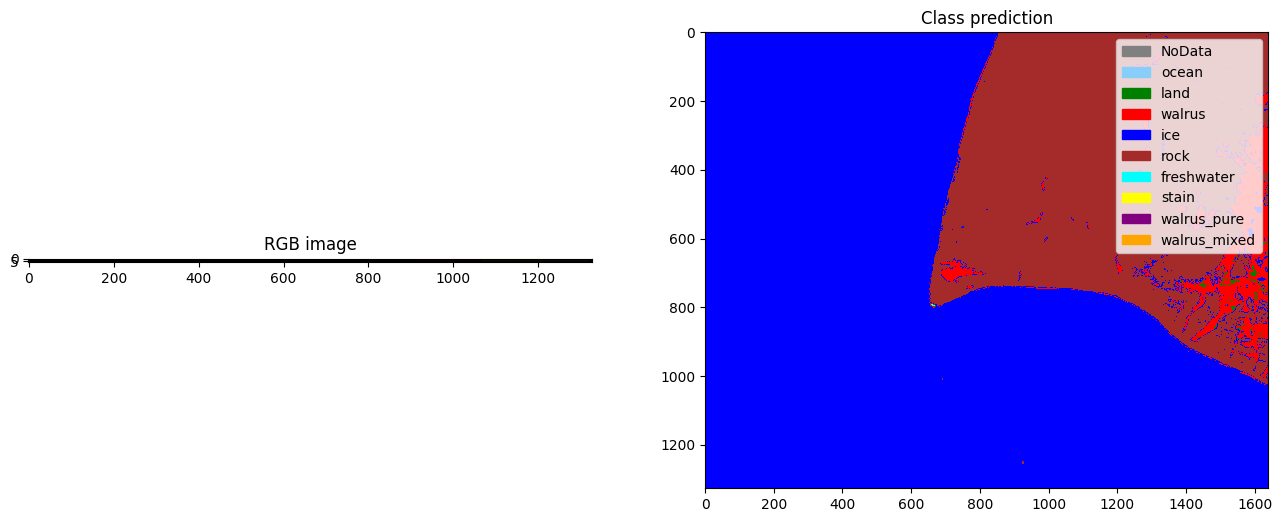

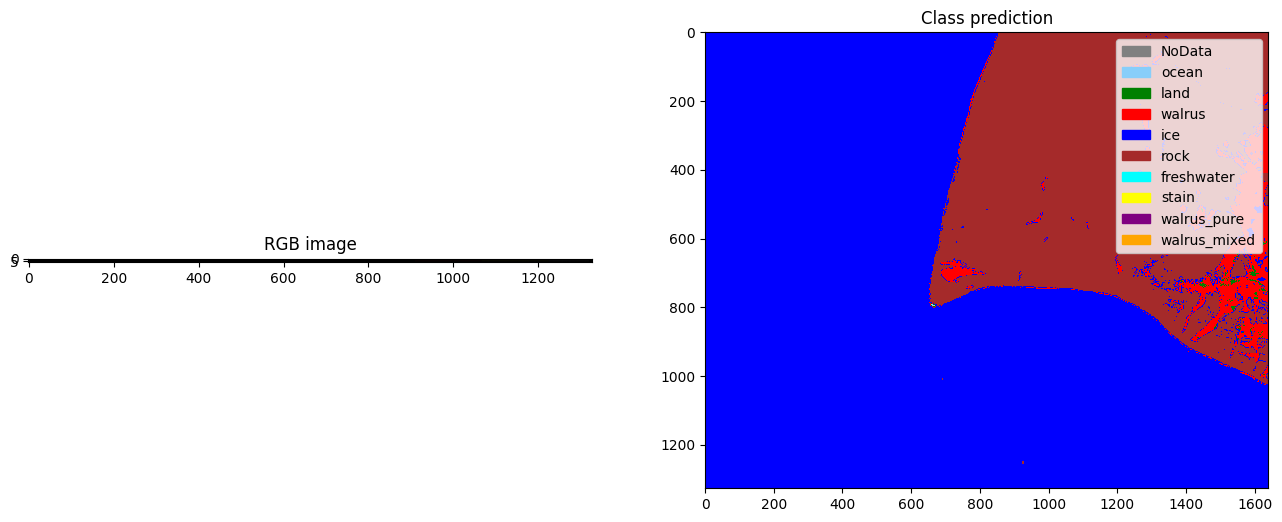

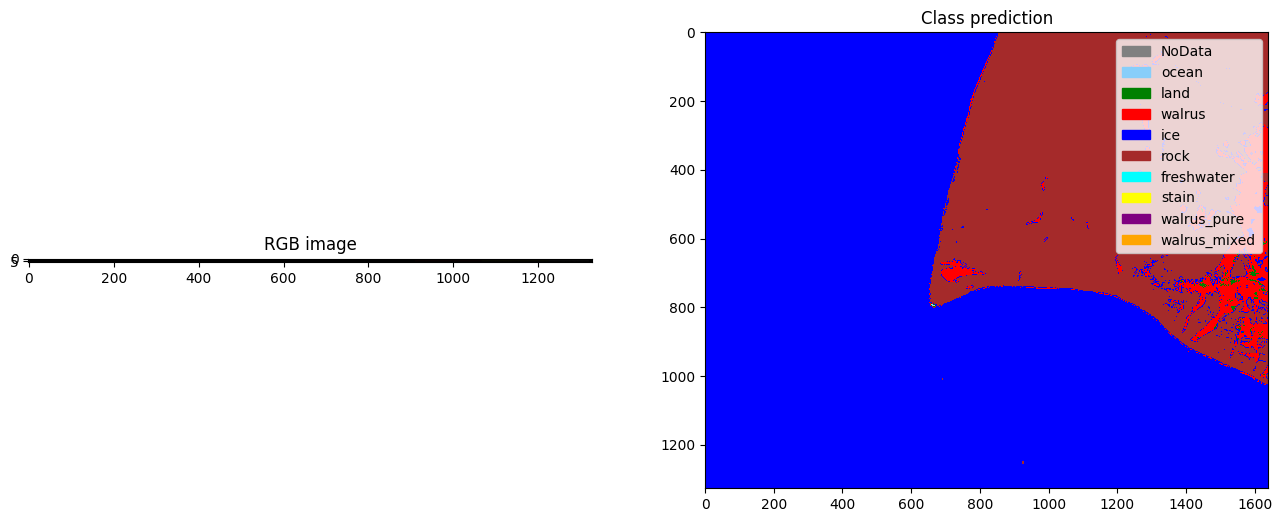

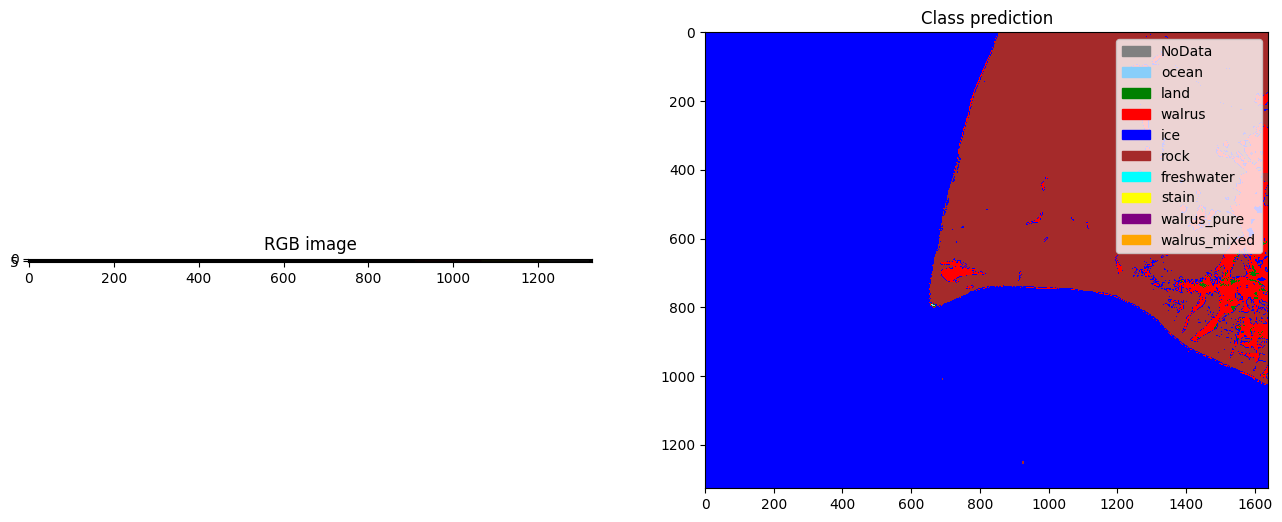

In [59]:
# Iterate over each pair of image and shapefile paths
for image_path, shapefile_path in image_shapefile_pairs:
    try:
        with rasterio.open(image_path) as img:
            bands = img.read()
            transform = img.transform
    except rasterio.errors.RasterioIOError:
        print(f"Error: Unable to open file {image_path}")
        continue

    # Load the shapefile
    try:
        img, roi = get_raster_and_mask(image_path, shapefile_path)
    except Exception as e:
        print(f"Error processing {image_path} and {shapefile_path}: {e}")
        continue

    # Rest of the processing steps (training, predictions, etc.) here...

    # Visualization
    img_rgb = colour_stretch(img, [2, 1, 0], (0, 4000))
    pred_cmap, patches, c_range = get_prediction_colourmap(class_prediction)

    plt.figure(figsize=(16, 10))
    plt.subplot(121)
    plt.imshow(img_rgb)
    plt.title("RGB image")

    plt.subplot(122)
    plt.imshow(class_prediction, cmap=pred_cmap, vmin=c_range[0], vmax=c_range[1])
    plt.legend(handles=patches)
    plt.title("Class prediction")

    plt.show()


In [ ]:
import os
import glob

# Directory containing image files
im_dir = "path/to/your/image/directory"
sh_dir = ""

# Get list of image files and corresponding shapefiles
image_files = glob.glob(os.path.join(image_dir, "*.tif"))
shapefile_files = [os.path.splitext(image_file)[0] + ".shp" for image_file in image_files]

# Iterate over each pair of image and shapefile paths
for image_path, shapefile_path in zip(image_files, shapefile_files):
    print(f"Processing {image_path} and {shapefile_path}")

    try:
        with rasterio.open(image_path) as img:
            bands = img.read()
            transform = img.transform
    except rasterio.errors.RasterioIOError:
        print(f"Error: Unable to open file {image_path}")
        continue

    # Load the shapefile
    try:
        img, roi = get_raster_and_mask(image_path, shapefile_path)
    except Exception as e:
        print(f"Error processing {image_path} and {shapefile_path}: {e}")
        continue

    # Rest of the processing steps (training, predictions, etc.) here...

    # Visualization
    img_rgb = colour_stretch(img, [2, 1, 0], (0, 4000))
    pred_cmap, patches, c_range = get_prediction_colourmap(class_prediction)

    plt.figure(figsize=(16, 10))
    plt.subplot(121)
    plt.imshow(img_rgb)
    plt.title(f"RGB image: {image_path}")

    plt.subplot(122)
    plt.imshow(class_prediction, cmap=pred_cmap, vmin=c_range[0], vmax=c_range[1])
    plt.legend(handles=patches)
    plt.title(f"Class prediction: {image_path}")

    plt.show()


In [ ]:
    # Extract spectral values for each class
    class_pixels = {}
    for label in np.unique(y_train):
        class_pixels[label] = X_train[y_train == label]

    # Compute mean spectral reflectance for each class
    class_means = {}
    for label, pixels in class_pixels.items():
        class_means[label] = np.mean(pixels, axis=0)

    # Compute standard deviation for each class
    class_stds = {}
    for label, pixels in class_pixels.items():
        class_stds[label] = np.std(pixels, axis=0)

In [ ]:

    # Plot mean spectral reflectance for each class with standard deviation
    plt.figure(figsize=(10, 6))
    for label, mean in class_means.items():
        std = class_stds[label]
        plt.plot(band_names, mean, label=label)
        plt.fill_between(band_names, mean - std, mean + std, alpha=0.2)

    plt.title('Mean Spectral Reflectance with Standard Deviation')
    plt.xlabel('Band')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.show()


this could potentially work with unlabeled images - need to move images into unlabeled folder and change file names


In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import numpy as np

# Function to plot the image, shapefile, and predicted classes
def plot_image_and_predictions(image_path, shapefile_path=None, predicted_classes=None):
    # Open the TIFF image
    with rasterio.open(image_path) as src:
        img = src.read()
        img = img.transpose(1, 2, 0)  

        # Plot the TIFF image
        fig, ax = plt.subplots(figsize=(10, 8))
        show(img, ax=ax, title=f"Image: {os.path.basename(image_path)}")

        # Plot the shapefile if provided
        if shapefile_path:
            shp_df = gpd.read_file(shapefile_path)
            shp_df.plot(ax=ax, facecolor="none", edgecolor="r")

        # Plot the predicted classes if provided
        if predicted_classes is not None:
            unique_classes = np.unique(predicted_classes)
            class_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
            for class_value, color in zip(unique_classes, class_colors):
                class_mask = np.ma.masked_array(img[:, :, 0], mask=~(predicted_classes == class_value))
                ax.imshow(class_mask, cmap='viridis', alpha=0.5, vmin=0, vmax=1)
                ax.contour(class_mask.mask, colors=color, linewidths=2)

            ax.set_title(f"Image: {os.path.basename(image_path)}, Predicted Classes: {', '.join(unique_classes)}")

        plt.show()

# Visualize the labeled images with their shapefiles and predicted classes
labeled_image_paths = glob.glob(f"{image_dir}/*.tif")

for image_path, shapefile_path in zip(labeled_image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    X = img[roi > 0, :]
    y = roi[roi > 0]

    # Predict the classes for the labeled image
    predicted_classes = rf.predict(X)

    # Plot the image, shapefile, and predicted classes
    plot_image_and_predictions(image_path, shapefile_path, predicted_classes)

# Visualize the unlabeled images with their predicted classes
unlabeled_image_paths = glob.glob(f"{image_dir}/unlabeled/*.tif")
X_unlabeled = []

for image_path in unlabeled_image_paths:
    img, _ = get_raster_and_mask(image_path, None)
    img = img.transpose(1, 2, 0)
    X_unlabeled.append(img.reshape(-1, img.shape[-1]))

X_unlabeled = np.vstack(X_unlabeled)
y_unlabeled = rf.predict(X_unlabeled)

for image_path, predicted_classes in zip(unlabeled_image_paths, y_unlabeled):
    # Plot the image and predicted classes
    plot_image_and_predictions(image_path, predicted_classes=predicted_classes)

This is me trying to plot the images to visually inspect the random forest 


In [41]:
img, roi = get_raster_and_mask(image_dir, shapefile_dir)

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(make_plotting_array(img))
plt.title("RGB image")

plt.subplot(122)
plt.imshow(roi)
plt.title("Training data")
plt.show()

RasterioIOError: C:/Users/Student/Documents/101_walrus_data/train/images: Permission denied

In [38]:
from rasterio.plot import show

def plot_image_and_predictions(image_path, shapefile_path, predicted_classes):
    # Open the TIFF image
    with rasterio.open(image_path) as src:
        img = src.read()

        # Plot the TIFF image
        fig, ax = plt.subplots(figsize=(10, 8))
        show(img, ax=ax, title=f"Image: {os.path.basename(image_path)}")

        # Plot the shapefile
        shp_df = gpd.read_file(shapefile_path)
        shp_df.plot(ax=ax, facecolor="none", edgecolor="r")

        # Plot the predicted classes
        unique_classes = np.unique(predicted_classes)
        class_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
        for class_value, color in zip(unique_classes, class_colors):
            class_mask = np.ma.masked_array(img[0], mask=~(predicted_classes == class_value))
            ax.imshow(class_mask, cmap='viridis', alpha=0.5, vmin=0, vmax=1)
            ax.contour(class_mask.mask, colors=color, linewidths=2)

        ax.set_title(f"Image: {os.path.basename(image_path)}, Predicted Classes: {', '.join(unique_classes)}")

        plt.show()

In [39]:
from rasterio.plot import show

def plot_image_and_predictions(image_path, shapefile_path, predicted_classes):
    # Open the TIFF image
    with rasterio.open(image_path) as src:
        img = src.read()

        # Plot the TIFF image
        fig, ax = plt.subplots(figsize=(10, 8))
        show(img, ax=ax, title=f"Image: {os.path.basename(image_path)}")

        # Plot the shapefile
        shp_df = gpd.read_file(shapefile_path)
        shp_df.plot(ax=ax, facecolor="none", edgecolor="r")

        # Plot the predicted classes
        unique_classes = np.unique(predicted_classes)
        class_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
        for class_value, color in zip(unique_classes, class_colors):
            class_mask = np.ma.masked_array(img[0], mask=~(predicted_classes == class_value))
            ax.imshow(class_mask, cmap='viridis', alpha=0.5, vmin=0, vmax=1)
            ax.contour(class_mask.mask, colors=color, linewidths=2)

        ax.set_title(f"Image: {os.path.basename(image_path)}, Predicted Classes: {', '.join(unique_classes)}")

        plt.show()
        plt.ion()